When it comes to deep learning, Theano is one of the essential libraries for efficient optimization of neural networks. In this write up, we tackle the standard MNIST data set using Theano, and we explore the implementation of a couple key techniques in neural network optimization: momentum and RMSProp. 

Our primary goal is to illustrate the basics of Theano and how it can be used to arrive at a good solution for this problem. 

### The dataset and our problem  

The MNIST data set is composed of gray-scale images of hand-drawn digits, from zero through nine.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

Thus, the data set has 785 columns, where the first column is the label, while the rest of the columns contain the pixel-values of the associated image.

In [348]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import theano
import theano.tensor as T
import os
%matplotlib inline

In [349]:
data = pd.read_csv(os.path.join('Data', 'train.csv'))

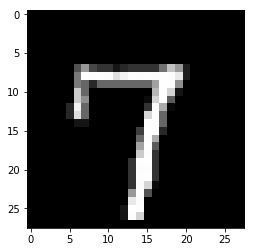

In [350]:
plt.figure()
plt.imshow(np.asarray(data.iloc[6, 1:]).reshape(28, 28), cmap='gray')

### Define helper functions

The first function simply tells us our error rate, which is the proportion of misclassified observations when compared to the target labels.

In [351]:
def error_rate(p, t):
    return np.mean(p != t)

Next, we normalize our data by subtracting the mean from each observation and dividing by the standard deviation. This will accelarate our convergence toward an optimal solutions as well as improve the accuracy of our classification.

In [352]:
def get_normalized_data(data):
    data = data.as_matrix().astype(np.float32)
    np.random.shuffle(data)
    X = data[:, 1:]
    mu = X.mean(axis=0)
    std = X.std(axis=0)
    np.place(std, std == 0, 1)
    X = (X - mu) / std # normalize the data
    Y = data[:, 0]
    return X, Y

We also create an indicator matrix to allow us to predict the probability of each class for a given observation.

In [353]:
def y2indicator(y):
    N = len(y)
    y = y.astype(np.int32)
    ind = np.zeros((N, 10))
    for i in range(N):
        ind[i, y[i]] = 1
    return ind

### Step 1: get the data and define our key variables  

First, we pull in the normalized data and define the number of training iterations (epochs). We also choose our learning rate and regularization parameter.

In [372]:
X, Y = get_normalized_data(data)

max_iter = 30
print_period = 10

lr = 0.00004
reg = 0.01

Next, we create a our train and test data sets.

In [373]:
Xtrain = X[:-1000,]
Ytrain = Y[:-1000]
Xtest  = X[-1000:,]
Ytest  = Y[-1000:]
Ytrain_ind = y2indicator(Ytrain)
Ytest_ind = y2indicator(Ytest)

We are doing only a single-layer neural network, and thus we need to define the dimensions of our input matrix (NxD), the weights of our hidden layer (DxM), and the hidden-layer-to-output weights (MxK). Our model will also have bias terms on either end of the hidden layer. 

In [374]:
N, D = Xtrain.shape
batch_sz = 500
n_batches = N / batch_sz
M = 300
K = 10
W1_init = np.random.randn(D, M) / 28
b1_init = np.zeros(M)
W2_init = np.random.randn(M, K) / np.sqrt(M)
b2_init = np.zeros(K)

### Step 2: define Theano variables and expressions  

First let's define our necessary variables, which are the matrices for our inputs and our targets. We also define our Theano shared variables, which can and will be updated through our training iterations. The hidden layer output matrix as well as our final output matrix are composed of expressions. We will use the rectifier linear unit (ReLU) activation function on the hidden layer, and the standard softmax function for the output matrix.

In [375]:
# inputs
thX = T.matrix('X')

# targets
thT = T.matrix('T')

# input-to-hidden-layer weights and bias
W1 = theano.shared(W1_init, 'W1')
b1 = theano.shared(b1_init, 'b1')

# hidden-layer-to-output weights and bias
W2 = theano.shared(W2_init, 'W2')
b2 = theano.shared(b2_init, 'b2')

# we can use the built-in theano functions to do relu and softmax
thZ = T.nnet.relu( thX.dot(W1) + b1 )
thY = T.nnet.softmax( thZ.dot(W2) + b2 )



The cost function takes into account regularization (we will use L2 regularization). The prediction function simply picks the class with the highest predicted probability for each given observation.

In [376]:
# define the cost function and prediction (theano automatically does the differentiation)
cost = -(thT * T.log(thY)).sum() + reg*((W1*W1).sum() + (b1*b1).sum() + (W2*W2).sum() + (b2*b2).sum())
prediction = T.argmax(thY, axis=1)

### Step 3: define training expressions and functions  

During the training process, we will be updating our shared variables (input weights, output weights, and biases). These will be updated using standard gradient descent along our defined cost function.

We define a theano function that takes our inputs and updates the shared variables accordingly.

In [377]:
update_W1 = W1 - lr*T.grad(cost, W1)
update_b1 = b1 - lr*T.grad(cost, b1)
update_W2 = W2 - lr*T.grad(cost, W2)
update_b2 = b2 - lr*T.grad(cost, b2)

train = theano.function(
    inputs=[thX, thT],
    updates=[(W1, update_W1), (b1, update_b1), (W2, update_W2), (b2, update_b2)],outputs=[cost, prediction]
)

Additionally, during the training process, we will keep track of our cost and prediction so that we can evaluate our training and final model. 

In [378]:
# create another function for this because we want it over the whole dataset
get_prediction = theano.function(
    inputs=[thX, thT],
    outputs=[cost, prediction],
)

### Step 4: training the model  

Lastly, we perform our training procedure using batch gradient descent. Every tenth iteration, we collect the total cost and the error rate of our model. Looking at the plot of our cost over time, we can see that the cost was still decreasing ever so slightly, meaning that we could have possibly gotten a lower error rate if we increased the number of training iterations.

Cost / err at iteration i=0, j=0: 2410.470 / 0.907
Cost / err at iteration i=2, j=0: 496.179 / 0.126
Cost / err at iteration i=4, j=0: 356.259 / 0.090
Cost / err at iteration i=6, j=0: 302.546 / 0.083
Cost / err at iteration i=8, j=0: 271.633 / 0.074
Cost / err at iteration i=10, j=0: 249.965 / 0.068
Cost / err at iteration i=12, j=0: 233.433 / 0.062
Cost / err at iteration i=14, j=0: 221.366 / 0.058
Cost / err at iteration i=16, j=0: 209.731 / 0.054
Cost / err at iteration i=18, j=0: 200.541 / 0.052
Cost / err at iteration i=20, j=0: 193.059 / 0.052
Cost / err at iteration i=22, j=0: 186.630 / 0.051
Cost / err at iteration i=24, j=0: 181.102 / 0.049
Cost / err at iteration i=26, j=0: 175.427 / 0.047
Cost / err at iteration i=28, j=0: 170.740 / 0.047
Cost / err at iteration i=29, j=0: 168.542 / 0.047


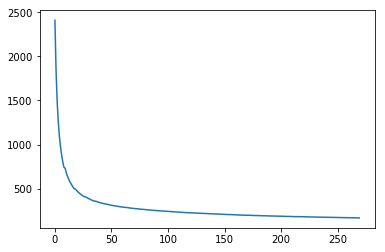

In [379]:
LL = []
for i in range(max_iter):
    Xtrain, Ytrain_ind = shuffle(Xtrain, Ytrain_ind)
    for j in range(int(n_batches)):
        Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
        Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]

        train(Xbatch, Ybatch)
        if j % print_period == 0:
            cost_val, prediction_val = get_prediction(Xtest, Ytest_ind)
            err = error_rate(prediction_val, Ytest)
            LL.append(cost_val)
            if (i % 2 == 0 or i % 29 == 0) and j % 100 == 0:
                print("Cost / err at iteration i=%d, j=%d: %.3f / %.3f" % (i, j, cost_val, err))

plt.plot(LL)
plt.show()

## With Momentum  

In gradient descent, [momentum](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Momentum) speeds up the convergence towards the minimum of the cost function by taking into account the previous weight change.

We can define velocity of the previous weight change as:

\begin{align}
\ v(t-1) = \triangle w(t-1)
\end{align}

We can update the weights as follows:

\begin{align}
\triangle w(t) = \mu v(t-1) - \eta \bigtriangledown J(t)
\end{align}

In pseudo-code form:  
`v = dw  
dw = (momentum)*v - (learning rate)*(cost gradient)  
w += dw`

### Step 1: get the data and define our key variables  

In order to incorporate momentum into our model, we need to first define our momentum rate 'mu,' which we will initially set as 0.9. 

In [380]:
X, Y = get_normalized_data(data)

max_iter = 30
print_period = 10

lr = 0.00004
reg = 0.01
mu = 0.9

Xtrain = X[:-1000,]
Ytrain = Y[:-1000]
Xtest  = X[-1000:,]
Ytest  = Y[-1000:]
Ytrain_ind = y2indicator(Ytrain)
Ytest_ind = y2indicator(Ytest)

N, D = Xtrain.shape
batch_sz = 500
n_batches = N / batch_sz

M = 300
K = 10
W1_init = np.random.randn(D, M) / 28
dW1_init = np.zeros((D, M))
b1_init = np.zeros(M)
db1_init = np.zeros(M)
W2_init = np.random.randn(M, K) / np.sqrt(M)
dW2_init = np.zeros((M, K))
b2_init = np.zeros(K)
db2_init = np.zeros(K)

### Step 2: define theano variables and expressions  

Next, we need to create variables that keep track of the change in our parameters. Above, we created matrices of zeroes with which we will initialize our new variables.

In [381]:
# inputs
thX = T.matrix('X')

# targets
thT = T.matrix('T')

# input-to-hidden-layer weights and bias
W1 = theano.shared(W1_init, 'W1')
dW1 = theano.shared(dW1_init, 'dW1')
b1 = theano.shared(b1_init, 'b1')
db1 = theano.shared(db1_init, 'db1')

# hidden-layer-to-output weights and bias
W2 = theano.shared(W2_init, 'W2')
dW2 = theano.shared(dW2_init, 'dW2')
b2 = theano.shared(b2_init, 'b2')
db2 = theano.shared(db2_init, 'db2')

# we can use the built-in theano functions to do relu and softmax
thZ = T.nnet.relu( thX.dot(W1) + b1 ) # relu is new in version 0.7.1 but just in case you don't have it
thY = T.nnet.softmax( thZ.dot(W2) + b2 )

# define the cost function and prediction (theano automatically does the differentiation)
cost = -(thT * T.log(thY)).sum() + reg*((W1*W1).sum() + (b1*b1).sum() + (W2*W2).sum() + (b2*b2).sum())
prediction = T.argmax(thY, axis=1)

### Step 3: define training expressions and functions  

The new shared variables (our deltas) will be updated through each iteration.

In [382]:
# updates
update_dW2 = mu*dW2 - lr*T.grad(cost, W2)

update_W2 = W2 + mu*dW2 - lr*T.grad(cost, W2)

update_db2 = mu*db2 - lr*T.grad(cost, b2)

update_b2 = b2 + mu*db2 - lr*T.grad(cost, b2)

update_dW1 = mu*dW1 - lr*T.grad(cost, W1)

update_W1 = W1 + mu*dW1 - lr*T.grad(cost, W1)

update_db1 = mu*db1 - lr*T.grad(cost, b1)

update_b1 = b1 + mu*db1 - lr*T.grad(cost, b1)

train = theano.function(
    inputs=[thX, thT],
    updates=[(W1, update_W1), (b1, update_b1), (W2, update_W2), (b2, update_b2)] +
    [(dW1, update_dW1), (dW2, update_dW2),(db2, update_db2), (db1, update_db1)]
)

In [383]:
# create another function for this because we want it over the whole dataset
get_prediction = theano.function(
    inputs=[thX, thT],
    outputs=[cost, prediction],
)

### Step 4: training the model  

When we execute our model with momentum incorporated, the advantage becomes apparent immediately, our solution converges much master our a lower error rate of 0.03. 

Cost / err at iteration i=0, j=0: 2325.724 / 0.839
Cost / err at iteration i=2, j=0: 218.201 / 0.060
Cost / err at iteration i=4, j=0: 166.388 / 0.049
Cost / err at iteration i=6, j=0: 142.304 / 0.044
Cost / err at iteration i=8, j=0: 129.169 / 0.039
Cost / err at iteration i=10, j=0: 120.625 / 0.034
Cost / err at iteration i=12, j=0: 114.360 / 0.033
Cost / err at iteration i=14, j=0: 109.979 / 0.031
Cost / err at iteration i=16, j=0: 107.022 / 0.030
Cost / err at iteration i=18, j=0: 105.149 / 0.029
Cost / err at iteration i=20, j=0: 103.811 / 0.029
Cost / err at iteration i=22, j=0: 103.053 / 0.028
Cost / err at iteration i=24, j=0: 102.454 / 0.028
Cost / err at iteration i=26, j=0: 102.201 / 0.028
Cost / err at iteration i=28, j=0: 102.222 / 0.027
Cost / err at iteration i=29, j=0: 102.278 / 0.028


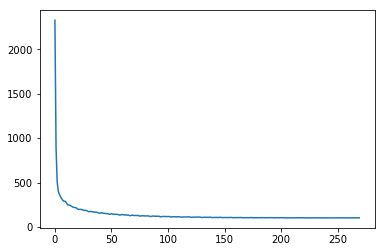

In [384]:
LL = []
for i in range(max_iter):
    #Xtrain, Ytrain_ind = shuffle(Xtrain, Ytrain_ind)
    for j in range(int(n_batches)):
        Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
        Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]

        train(Xbatch, Ybatch)
        if j % print_period == 0:
            cost_val, prediction_val = get_prediction(Xtest, Ytest_ind)
            err = error_rate(prediction_val, Ytest)
            LL.append(cost_val)
            if (i % 2 == 0 or i % 29 == 0) and j % 100 == 0:
                print("Cost / err at iteration i=%d, j=%d: %.3f / %.3f" % (i, j, cost_val, err))

plt.plot(LL)
plt.show()

# With RMSProp  

[RMSProp](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) (for Root Mean Square Propagation) is a method in which the learning rate is adapted for each of the parameters. The idea is to divide the learning rate for a weight by a running average of the magnitudes of recent gradients for that weight. So, first the running average, or cache, is calculated in terms of means square,

\begin{align}
\ v(w,t) := \gamma v(w, t-1)+(1-\gamma)(\bigtriangledown Q_i(w))^2
\end{align}

where gamma is the forgetting factor or decay rate.

The parameters are updates as,

\begin{align}
\ w := w - \frac{\eta}{\sqrt{v(w,t)}}\bigtriangledown Q_i(w)
\end{align}

Or, in pseudo-code:  
`cache = decay_rate*cache + (1 - decay_rate)*gradient^2  
w -= learning_rate*gradient / (sqrt(cache) + epsilon)  
`

### Step 1: get the data and define our key variables  

In order to incorporate RMSProp into our model, we need to first define our decay rate, which we will initially set as 0.999, and we wil also add a small non-zero value for epsilon so that we are not dividing by zero.

In [403]:
X, Y = get_normalized_data(data)

max_iter = 30
print_period = 10

lr = np.float32(0.001)
reg = np.float32(10e-12)
decay_rate = np.float32(.999)
eps = np.float32(0.0000000001) # so that we don't divide by zero

Xtrain = X[:-1000,]
Ytrain = Y[:-1000]
Xtest  = X[-1000:,]
Ytest  = Y[-1000:]
Ytrain_ind = y2indicator(Ytrain)
Ytest_ind = y2indicator(Ytest)

N, D = Xtrain.shape
batch_sz = 500
n_batches = N / batch_sz

M = 300
K = 10
W1_init = np.random.randn(D, M) / 28
cache_W1_init = np.zeros((D, M))
b1_init = np.zeros(M)
cache_b1_init = np.zeros(M)
W2_init = np.random.randn(M, K) / np.sqrt(M)
cache_W2_init = np.zeros((M, K))
b2_init = np.zeros(K)
cache_b2_init = np.zeros(K)

### Step 2: define theano variables and expressions  

Next, we need to create variables that keep track of the cache of our recent gradients. Above, we created matrices of zeroes with which we will initialize our new variables.

In [404]:
# step 2: define theano variables and expressions

# inputs
thX = T.matrix('X')

# targets
thT = T.matrix('T')

# input-to-hidden-layer weights and bias
W1 = theano.shared(W1_init, 'W1')
cache_W1 = theano.shared(cache_W1_init, 'cache_W1')
b1 = theano.shared(b1_init, 'b1')
cache_b1 = theano.shared(cache_b1_init, 'cache_b1')

# hidden-layer-to-output weights and bias
W2 = theano.shared(W2_init, 'W2')
cache_W2 = theano.shared(cache_W2_init, 'cache_W2')
b2 = theano.shared(b2_init, 'b2')
cache_b2 = theano.shared(cache_b2_init, 'cache_b2')

# we can use the built-in theano functions to do relu and softmax
thZ = T.nnet.relu( thX.dot(W1) + b1 ) # relu is new in version 0.7.1 but just in case you don't have it
thY = T.nnet.softmax( thZ.dot(W2) + b2 )

# define the cost function and prediction (theano automatically does the differentiation)
cost = -(thT * T.log(thY)).sum() + reg*((W1*W1).sum() + (b1*b1).sum() + (W2*W2).sum() + (b2*b2).sum())
prediction = T.argmax(thY, axis=1)

### Step 3: define training expressions and functions  

The new shared variables (our cached gradients) will be updated through each iteration.

In [405]:
update_cache_W2 = decay_rate*cache_W2 + (np.float32(1) - decay_rate)*T.grad(cost, W2)*T.grad(cost, W2)
update_W2 = W2  - lr*T.grad(cost, W2) / (T.sqrt(cache_W2) + eps)

update_cache_b2 = decay_rate*cache_b2 + (np.float32(1) - decay_rate)*T.grad(cost, b2)*T.grad(cost, b2)
update_b2 = b2  - lr*T.grad(cost, b2) / (T.sqrt(cache_b2) + eps)

update_cache_W1 = decay_rate*cache_W1 + (np.float32(1) - decay_rate)*T.grad(cost, W1)*T.grad(cost, W1)
update_W1 = W1  - lr*T.grad(cost, W1) / (T.sqrt(cache_W1) + eps)

update_cache_b1 = decay_rate*cache_b1 + (np.float32(1) - decay_rate)*T.grad(cost, b1)*T.grad(cost, b1)
update_b1 = b1  - lr*T.grad(cost, b1) / (T.sqrt(cache_b1) + eps)

train = theano.function(
    inputs=[thX, thT],
    updates=[(cache_W1, update_cache_W1), (cache_W2, update_cache_W2), 
             (cache_b1, update_cache_b1), (cache_b2, update_cache_b2)]   
)

train2 = theano.function(
    inputs=[thX, thT],
    updates=[(W1, update_W1), (b1, update_b1), (W2, update_W2), (b2, update_b2)]
    
)

In [406]:
# create another function for this because we want it over the whole dataset
get_prediction = theano.function(
    inputs=[thX, thT],
    outputs=[cost, prediction],
)

### Step 4: training the model  

When we execute our model with momentum incorporated, the advantage becomes apparent immediately, our solution is comparable to the one we achieved with momentum. 

Cost / err at iteration i=0, j=0: 2482.705 / 0.389
Cost / err at iteration i=2, j=0: 115.293 / 0.031
Cost / err at iteration i=4, j=0: 106.673 / 0.025
Cost / err at iteration i=6, j=0: 102.615 / 0.026
Cost / err at iteration i=8, j=0: 103.861 / 0.025
Cost / err at iteration i=10, j=0: 108.116 / 0.026
Cost / err at iteration i=12, j=0: 111.520 / 0.026
Cost / err at iteration i=14, j=0: 114.464 / 0.027
Cost / err at iteration i=16, j=0: 117.215 / 0.027
Cost / err at iteration i=18, j=0: 120.086 / 0.027
Cost / err at iteration i=20, j=0: 122.561 / 0.027
Cost / err at iteration i=22, j=0: 125.061 / 0.026
Cost / err at iteration i=24, j=0: 127.337 / 0.026
Cost / err at iteration i=26, j=0: 129.465 / 0.026
Cost / err at iteration i=28, j=0: 131.443 / 0.026
Cost / err at iteration i=29, j=0: 132.381 / 0.026


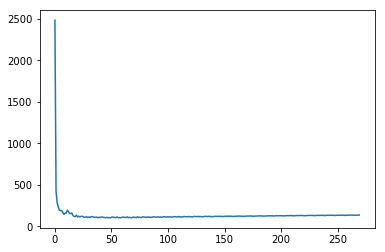

In [407]:
LL = []
for i in range(max_iter):
    #Xtrain, Ytrain_ind = shuffle(Xtrain, Ytrain_ind)
    for j in range(int(n_batches)):
        Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
        Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]

        train(Xbatch, Ybatch)
        train2(Xbatch, Ybatch)
        if j % print_period == 0:
            cost_val, prediction_val = get_prediction(Xtest, Ytest_ind)
            err = error_rate(prediction_val, Ytest)
            LL.append(cost_val)
            if (i % 2 == 0 or i % 29 == 0) and j % 100 == 0:
                print("Cost / err at iteration i=%d, j=%d: %.3f / %.3f" % (i, j, cost_val, err))
plt.plot(LL)
plt.show()

# With RMSProp and Momentum

When we combine RMSProp and momentum, we see that our error rate is actually higher than the models with only RMSProp or momentum. This is an indication that our hyperparameters need tuning. 

In [420]:
# step 1: get the data and define all the usual variables
X, Y = get_normalized_data(data)

max_iter = 30
print_period = 10

lr = np.float32(10e-7)
reg = np.float32(10-12)
mu = np.float32(0.99)
decay_rate = np.float32(.999)
eps = np.float32(0.0000000001) # so that we don't divide by zero

Xtrain = X[:-1000,]
Ytrain = Y[:-1000]
Xtest  = X[-1000:,]
Ytest  = Y[-1000:]
Ytrain_ind = y2indicator(Ytrain)
Ytest_ind = y2indicator(Ytest)

N, D = Xtrain.shape
batch_sz = 500
n_batches = N / batch_sz

M = 300
K = 10
W1_init = np.random.randn(D, M) / 28
dW1_init = np.zeros((D, M))
cache_W1_init = np.zeros((D, M))
b1_init = np.zeros(M)
db1_init = np.zeros(M)
cache_b1_init = np.zeros(M)
W2_init = np.random.randn(M, K) / np.sqrt(M)
dW2_init = np.zeros((M, K))
cache_W2_init = np.zeros((M, K))
b2_init = np.zeros(K)
db2_init = np.zeros(K)
cache_b2_init = np.zeros(K)

In [421]:
Xtrain.shape

(41000, 784)

In [422]:
# step 2: define theano variables and expressions

# inputs
thX = T.matrix('X')

# targets
thT = T.matrix('T')

# input-to-hidden-layer weights and bias
W1 = theano.shared(W1_init, 'W1')
dW1 = theano.shared(dW1_init, 'dW1')
cache_W1 = theano.shared(cache_W1_init, 'cache_W1')
b1 = theano.shared(b1_init, 'b1')
db1 = theano.shared(db1_init, 'db1')
cache_b1 = theano.shared(cache_b1_init, 'cache_b1')

# hidden-layer-to-output weights and bias
W2 = theano.shared(W2_init, 'W2')
dW2 = theano.shared(dW2_init, 'dW2')
cache_W2 = theano.shared(cache_W2_init, 'cache_W2')
b2 = theano.shared(b2_init, 'b2')
db2 = theano.shared(db2_init, 'db2')
cache_b2 = theano.shared(cache_b2_init, 'cache_b2')

# we can use the built-in theano functions to do relu and softmax
thZ = T.nnet.relu( thX.dot(W1) + b1 ) # relu is new in version 0.7.1 but just in case you don't have it
thY = T.nnet.softmax( thZ.dot(W2) + b2 )

# define the cost function and prediction (theano automatically does the differentiation)
cost = -(thT * T.log(thY)).sum() + reg*((W1*W1).sum() + (b1*b1).sum() + (W2*W2).sum() + (b2*b2).sum())
prediction = T.argmax(thY, axis=1)

In [423]:
update_dW2 = mu*dW2 - lr*T.grad(cost, W2) / (T.sqrt(cache_W2) + eps)
update_cache_W2 = decay_rate*cache_W2 + (np.float32(1) - decay_rate)*T.grad(cost, W2)*T.grad(cost, W2)
update_W2 = W2 + mu*dW2 - lr*T.grad(cost, W2) / (T.sqrt(cache_W2) + eps)


update_db2 = mu*db2 - lr*T.grad(cost, b2) / (T.sqrt(cache_b2) + eps)
update_cache_b2 = decay_rate*cache_b2 + (np.float32(1) - decay_rate)*T.grad(cost, b2)*T.grad(cost, b2)
update_b2 = b2 + mu*db2 - lr*T.grad(cost, b2) / (T.sqrt(cache_b2) + eps)

update_dW1 = mu*dW1 - lr*T.grad(cost, W1) / (T.sqrt(cache_W1) + eps)
update_cache_W1 = decay_rate*cache_W1 + (np.float32(1) - decay_rate)*T.grad(cost, W1)*T.grad(cost, W1)
update_W1 = W1 + mu*dW1 - lr*T.grad(cost, W1) / (T.sqrt(cache_W1) + eps)

update_db1 = mu*db1 - lr*T.grad(cost, b1) / (T.sqrt(cache_b1) + eps)
update_cache_b1 = decay_rate*cache_b1 + (np.float32(1) - decay_rate)*T.grad(cost, b1)*T.grad(cost, b1)
update_b1 = b1 + mu*db1 - lr*T.grad(cost, b1) / (T.sqrt(cache_b1) + eps)

train = theano.function(
    inputs=[thX, thT],
    updates=[(cache_W1, update_cache_W1), (cache_W2, update_cache_W2), 
             (cache_b1, update_cache_b1), (cache_b2, update_cache_b2)]
)

train2 = theano.function(
    inputs=[thX, thT],
    updates=[(W1, update_W1), (b1, update_b1), (W2, update_W2), (b2, update_b2)] +
    [(dW1, update_dW1), (dW2, update_dW2),(db2, update_db2), (db1, update_db1)]
)

In [424]:
# create another function for this because we want it over the whole dataset
get_prediction = theano.function(
    inputs=[thX, thT],
    outputs=[cost, prediction],
)

Cost / err at iteration i=0, j=0: 1891.141 / 0.911
Cost / err at iteration i=2, j=0: -992.135 / 0.111
Cost / err at iteration i=4, j=0: -2633.315 / 0.084
Cost / err at iteration i=6, j=0: -4676.145 / 0.074
Cost / err at iteration i=8, j=0: -7008.585 / 0.068
Cost / err at iteration i=10, j=0: -9627.492 / 0.060
Cost / err at iteration i=12, j=0: -12562.862 / 0.055
Cost / err at iteration i=14, j=0: -15842.929 / 0.054
Cost / err at iteration i=16, j=0: -19492.394 / 0.052
Cost / err at iteration i=18, j=0: -23530.431 / 0.049
Cost / err at iteration i=20, j=0: -27969.247 / 0.048
Cost / err at iteration i=22, j=0: -32813.259 / 0.046
Cost / err at iteration i=24, j=0: -38066.610 / 0.045
Cost / err at iteration i=26, j=0: -43731.936 / 0.042
Cost / err at iteration i=28, j=0: -49807.704 / 0.043
Cost / err at iteration i=29, j=0: -52997.533 / 0.043


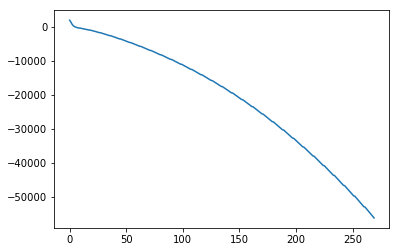

In [425]:
LL = []
for i in range(max_iter):
    #Xtrain, Ytrain_ind = shuffle(Xtrain, Ytrain_ind)
    for j in range(int(n_batches)):
        Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
        Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]

        train(Xbatch, Ybatch)
        train2(Xbatch, Ybatch)
        if j % print_period == 0:
            cost_val, prediction_val = get_prediction(Xtest, Ytest_ind)
            err = error_rate(prediction_val, Ytest)
            LL.append(cost_val)
            if (i % 2 == 0 or i % 29 == 0) and j % 100 == 0:
                print("Cost / err at iteration i=%d, j=%d: %.3f / %.3f" % (i, j, cost_val, err))

plt.plot(LL)
plt.show()